# Лабораторная работа №4. Разработка алгоритма детекции наличия маски на изображении

In [1]:
import os
import shutil
import pathlib
import cv2

import matplotlib.pyplot as plt
import numpy as np

from ipywidgets import interact
from IPython.display import Image
from PIL import Image as PImage
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import image_dataset_from_directory


# Второй датасет: реализация через Sklearn
### Импорт второго датасета

In [29]:
original_dir2 = pathlib.Path("data/masks-data/dataset2/dataset")

### Определение размеров изображений

In [6]:
wds2 = []
hts2 = []
for ctg in ("with_mask", "without_mask"):
  for filename in os.listdir(original_dir2 / ctg):
    im = PImage.open(original_dir2 / ctg / filename)
    # if im.size[0] > 3000 or im.size[1] > 3000:
    #   large_imgs.append(im)
    wds2.append(im.size[0])
    hts2.append(im.size[1])

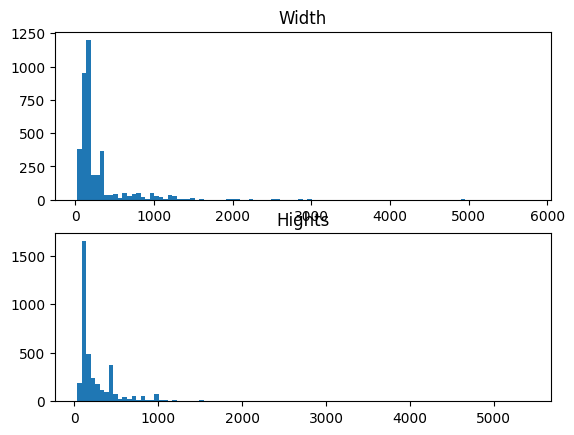

In [7]:
fig, axs = plt.subplots(2)
axs[0].hist(wds2, bins=100)
axs[0].set_title('Width')
axs[1].hist(hts2, bins=100)
axs[1].set_title('Hights')
plt.show()

In [8]:
print(f"{stats.mode(wds2)}, {stats.mode(hts2)}")

ModeResult(mode=320, count=261), ModeResult(mode=428, count=213)


### Загрузка изображений

In [9]:
def load_images_from_folder(folder):
  images = []
  classes = []
  for ctg in ("with_mask", "without_mask"):
    path = f'{folder}/{ctg}'
    for filename in os.listdir(path):
      img = cv2.imread(os.path.join(path, filename))
      if img is not None:
        images.append(np.array(cv2.resize(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY), (150, 150)) / 255).flatten())
        classes.append(1 if ctg == 'with_mask' else 0)
  return classes, images

img_classes2, imgs2 = load_images_from_folder(original_dir2)

libpng warning: iCCP: known incorrect sRGB profile


In [10]:
print(img_classes2[0], imgs2[0].shape)

1 (22500,)


### Разделение на выборки

In [11]:
x_train2, x_test2, y_train2, y_test2 = train_test_split(imgs2, img_classes2, test_size=0.2, random_state=42)

## Классификация изображений

*см. Вандер Плас (стр 487 "Метод главных компонент")*

In [12]:
pca2 = PCA(n_components=10, whiten=True, random_state=42)
svc2 = SVC(C=50, gamma=0.005, kernel='rbf', class_weight='balanced')
model21 = make_pipeline(pca2, svc2)

In [13]:
model21.fit(x_train2, y_train2)

Pipeline(steps=[('pca', PCA(n_components=10, random_state=42, whiten=True)),
                ('svc', SVC(C=50, class_weight='balanced', gamma=0.005))])

In [14]:
y_model21 = model21.predict(x_test2)

In [15]:
print(accuracy_score(y_test2, y_model21))
print(classification_report(y_test2, y_model21))
print(confusion_matrix(y_test2, y_model21))

0.8044328552803129
              precision    recall  f1-score   support

           0       0.74      0.89      0.81       361
           1       0.88      0.73      0.80       406

    accuracy                           0.80       767
   macro avg       0.81      0.81      0.80       767
weighted avg       0.82      0.80      0.80       767

[[321  40]
 [110 296]]


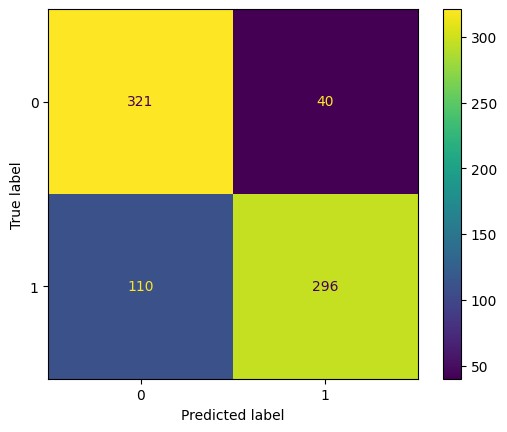

In [16]:
_ = ConfusionMatrixDisplay.from_estimator(model21, x_test2, y_test2)

## K ближайших соседей

In [17]:
knn2 = KNeighborsClassifier()
model22 = make_pipeline(pca2, knn2)

In [19]:
model22.fit(x_train2, y_train2)

Pipeline(steps=[('pca', PCA(n_components=10, random_state=42, whiten=True)),
                ('kneighborsclassifier', KNeighborsClassifier())])

In [20]:
y_model22 = model22.predict(x_test2)

In [21]:
print(accuracy_score(y_test2, y_model22))
print(classification_report(y_test2, y_model22))
print(confusion_matrix(y_test2, y_model22))

0.7979139504563233
              precision    recall  f1-score   support

           0       0.75      0.86      0.80       361
           1       0.86      0.74      0.79       406

    accuracy                           0.80       767
   macro avg       0.80      0.80      0.80       767
weighted avg       0.81      0.80      0.80       767

[[312  49]
 [106 300]]


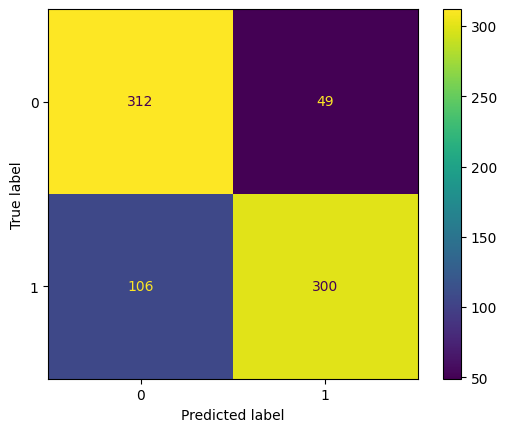

In [22]:
_ = ConfusionMatrixDisplay.from_estimator(model22, x_test2, y_test2)

### Кросс-валидация

In [23]:
kfold2 = KFold(n_splits=5)

results21 = cross_val_score(model21, np.array(imgs2), img_classes2, cv=kfold2)
print("Accuracy: %.7f (%.7f)" % (results21.mean(), results21.std()))
print(*results21, sep='\n')

Accuracy: 0.8158418 (0.0548825)
0.7561929595827901
0.7522816166883963
0.817470664928292
0.8707571801566579
0.8825065274151436


In [24]:
results22 = cross_val_score(model22, np.array(imgs2), img_classes2, cv=kfold2)
print("Accuracy: %.7f (%.7f)" % (results22.mean(), results22.std()))
print(*results22, sep='\n')

Accuracy: 0.7440824 (0.0583760)
0.6727509778357236
0.6766623207301173
0.8148631029986962
0.7715404699738904
0.7845953002610966


# Второй датасет: реализация через Keras

In [2]:
new_base_dir2 = pathlib.Path("data/masks-data/masks2")

In [28]:
def make_subset2(subset_name, start_index, end_index):
  for category in ("with_mask", "without_mask"):
    dir = new_base_dir2 / subset_name / category
    os.makedirs(dir)
    c = 0
    for fname in os.listdir(original_dir2 / category):
      if c >= start_index and c < end_index:
        shutil.copyfile(src=original_dir2 / category / fname, dst=dir / fname)
      c += 1

In [ ]:
make_subset2("train", start_index=0, end_index=1340)
make_subset2("validation", start_index=1340, end_index=1723)
make_subset2("test", start_index=1723, end_index=1915)

In [3]:
w2 = 180
h2 = 180

In [4]:
train_dataset2 = image_dataset_from_directory(new_base_dir2 / "train",
                                              image_size=(w2, h2),
                                              batch_size=32)
validation_dataset2 = image_dataset_from_directory(new_base_dir2 / "validation",
                                                   image_size=(w2, h2),
                                                   batch_size=32)
test_dataset2 = image_dataset_from_directory(new_base_dir2 / "test",
                                             image_size=(w2, h2),
                                             batch_size=32)

Found 2680 files belonging to 2 classes.
Found 766 files belonging to 2 classes.
Found 384 files belonging to 2 classes.


In [5]:
conv_base = keras.applications.vgg16.VGG16(weights="imagenet",
                                           include_top=False,
                                           input_shape=(180, 180, 3))

In [6]:
conv_base.trainable = False

In [7]:
inputs = keras.Input(shape=(180, 180, 3))
x = keras.applications.vgg16.preprocess_input(inputs)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model2 = keras.Model(inputs, outputs)
model2.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [8]:
callbacks = [keras.callbacks.ModelCheckpoint(filepath="ds2.keras",
                                             save_best_only=True,
                                             monitor="val_loss")]

In [11]:
from tensorflow.python.compiler.mlcompute import mlcompute; 
mlcompute.set_mlc_device(device_name='gpu')

ModuleNotFoundError: No module named 'tensorflow.python.compiler.mlcompute'

In [12]:
history = model2.fit(train_dataset2,
                    epochs=5,
                    validation_data=validation_dataset2,
                    callbacks=callbacks)

Epoch 1/5
 8/84 ━━━━━━━━━━━━━━━━━━━━ 2:25 2s/step - accuracy: 0.9965 - loss: 0.3415

2024-10-14 20:08:43.193646: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


84/84 ━━━━━━━━━━━━━━━━━━━━ 213s 3s/step - accuracy: 0.9908 - loss: 0.7259 - val_accuracy: 0.9896 - val_loss: 1.2664
Epoch 2/5
33/84 ━━━━━━━━━━━━━━━━━━━━ 1:31 2s/step - accuracy: 0.9965 - loss: 0.1451

2024-10-14 20:13:00.140891: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


84/84 ━━━━━━━━━━━━━━━━━━━━ 197s 2s/step - accuracy: 0.9966 - loss: 0.1620 - val_accuracy: 0.9935 - val_loss: 0.9172
Epoch 3/5
 8/84 ━━━━━━━━━━━━━━━━━━━━ 2:26 2s/step - accuracy: 1.0000 - loss: 0.0000e+00

2024-10-14 20:15:33.053133: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


84/84 ━━━━━━━━━━━━━━━━━━━━ 197s 2s/step - accuracy: 0.9985 - loss: 0.1025 - val_accuracy: 0.9922 - val_loss: 1.1717
Epoch 4/5
23/84 ━━━━━━━━━━━━━━━━━━━━ 1:50 2s/step - accuracy: 1.0000 - loss: 2.5280e-10

2024-10-14 20:19:16.641678: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


84/84 ━━━━━━━━━━━━━━━━━━━━ 193s 2s/step - accuracy: 0.9992 - loss: 0.0334 - val_accuracy: 0.9922 - val_loss: 1.0035
Epoch 5/5


2024-10-14 20:21:47.733202: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile


84/84 ━━━━━━━━━━━━━━━━━━━━ 202s 2s/step - accuracy: 1.0000 - loss: 2.3324e-05 - val_accuracy: 0.9935 - val_loss: 0.7281


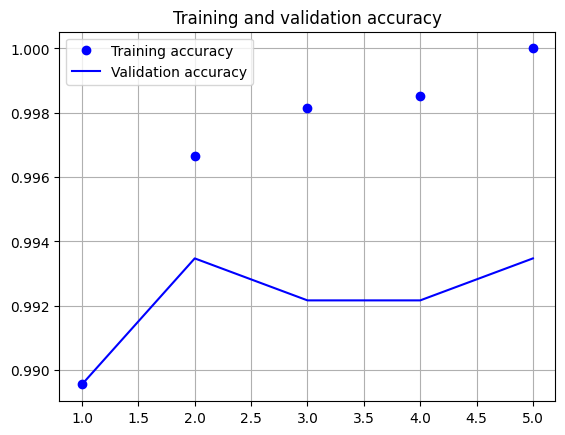

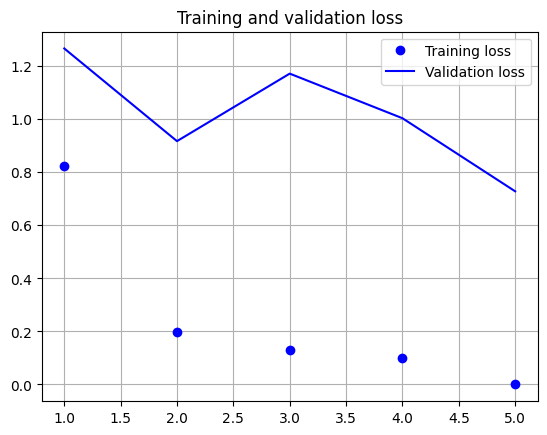

In [13]:
def plot_acc_loss():
  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]
  epochs = range(1, len(accuracy) + 1)
  plt.plot(epochs, accuracy, "bo", label="Training accuracy")
  plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
  plt.title("Training and validation accuracy")
  plt.legend()
  plt.grid()
  plt.figure()
  plt.plot(epochs, loss, "bo", label="Training loss")
  plt.plot(epochs, val_loss, "b", label="Validation loss")
  plt.title("Training and validation loss")
  plt.legend()
  plt.grid()
  plt.show()

plot_acc_loss()

In [14]:
test_model2 = keras.models.load_model("ds2.keras")
test_loss2, test_acc2 = test_model2.evaluate(test_dataset2)
print(f"Test accuracy: {test_acc2:.3f}")

12/12 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 1.0000 - loss: 0.0000e+00
Test accuracy: 1.000
